Khai báo Thư Viện

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

Lấy đường dẫn các hình ảnh và chia tập dữ liệu thành 2 phần train và test (phần train gồm 9 ảnh và phần test có 1 ảnh)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_folder = '/content/drive/MyDrive/AT&T_dataset/'
test_imgs = ('10.pgm')

dt_train = []
dt_test = []
y_train = []
y_test = []

for i in os.listdir(data_folder):
  for j in os.listdir(os.path.join(data_folder, i)):
    if j in test_imgs:
      dt_test.append(os.path.join(data_folder, i, j))
      y_test.append(i)
      continue
    dt_train.append(os.path.join(data_folder, i, j))
    y_train.append(i)

In [ ]:
df = pd.DataFrame({'Image_path' : dt_train, 'Label' : y_train})
test_df = pd.DataFrame({'Image_path' : dt_test, 'Label' : y_test})

Các hàm cần sử dụng trong quá trình rút trích đặc trưng:

1.   Hàm xây dựng mô hình (VGG16)
2.   Hàm chuyển ảnh thành vector
3.   Hàm rút trích đặc trưng



In [ ]:
def get_extract_model():
    vgg16_model = VGG16(weights="imagenet")
    extract_model = Model(inputs=vgg16_model.inputs, outputs = vgg16_model.get_layer("fc1").output)
    return extract_model

def image_preprocess(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print(image_path)
    img = image.load_img(image_path, target_size=(224, 224))
    img_tensor = image_preprocess(img)
    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

Mô hình rút trích đặc trưng có 21 lớp

In [ ]:
extract_model = get_extract_model()

553467096/553467096 [==============================] - 9s 0us/step


In [ ]:
extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Rút trích đặc trưng cho từng ảnh trong tập train

In [ ]:
vectors = []
for i in df.index:
  image_path = df['Image_path'].iloc[i]
  image_vector = extract_vector(extract_model,image_path)
  vectors.append(image_vector)
train = pd.DataFrame(vectors)
train['Image_path'] = df['Image_path']
train['Label'] = df['Label']
train['Label'] = [int(train['Label'][i][1:]) - 1 for i in train['Label'].index]

/content/drive/MyDrive/AT&T_dataset/s38/2.pgm
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/AT&T_dataset/s38/8.pgm
1/1 [==============================] - 1s 938ms/step
/content/drive/MyDrive/AT&T_dataset/s38/6.pgm
1/1 [==============================] - 1s 596ms/step
/content/drive/MyDrive/AT&T_dataset/s38/9.pgm
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/AT&T_dataset/s38/7.pgm
1/1 [==============================] - 1s 568ms/step
/content/drive/MyDrive/AT&T_dataset/s38/5.pgm
1/1 [==============================] - 1s 582ms/step
/content/drive/MyDrive/AT&T_dataset/s38/3.pgm
1/1 [==============================] - 1s 578ms/step
/content/drive/MyDrive/AT&T_dataset/s38/1.pgm
1/1 [==============================] - 1s 596ms/step
/content/drive/MyDrive/AT&T_dataset/s38/4.pgm
1/1 [==============================] - 1s 705ms/step
/content/drive/MyDrive/AT&T_dataset/s6/7.pgm
1/1 [==============================] - 1s 587ms/step
/content/drive/My

In [ ]:
train.shape

(360, 4098)

Xây dựng mô hình dự đoán có 2 lớp Dense

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(4096,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(40)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1048832   
                                                                 
 dense_1 (Dense)             (None, 40)                10280     
                                                                 
Total params: 1,059,112
Trainable params: 1,059,112
Non-trainable params: 0
_________________________________________________________________


Biên dịch mô hình

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Huấn luyện mô hình

In [ ]:
model.fit(train.drop(columns=['Image_path', 'Label']), train['Label'], epochs=20)

Epoch 1/20
12/12 [==============================] - 1s 9ms/step - loss: 3.6543 - accuracy: 0.0806
Epoch 2/20
12/12 [==============================] - 0s 11ms/step - loss: 3.4802 - accuracy: 0.4139
Epoch 3/20
12/12 [==============================] - 0s 9ms/step - loss: 3.2914 - accuracy: 0.4472
Epoch 4/20
12/12 [==============================] - 0s 11ms/step - loss: 3.0696 - accuracy: 0.7389
Epoch 5/20
12/12 [==============================] - 0s 10ms/step - loss: 2.8240 - accuracy: 0.7944
Epoch 6/20
12/12 [==============================] - 3s 11ms/step - loss: 2.5638 - accuracy: 0.8917
Epoch 7/20
12/12 [==============================] - 0s 9ms/step - loss: 2.2836 - accuracy: 0.9583
Epoch 8/20
12/12 [==============================] - 0s 10ms/step - loss: 2.0285 - accuracy: 0.9583
Epoch 9/20
12/12 [==============================] - 0s 9ms/step - loss: 1.7647 - accuracy: 0.9722
Epoch 10/20
12/12 [==============================] - 0s 10ms/step - loss: 1.5161 - accuracy: 0.9833
Epoch 11/20
1

Rút trích đặc trưng cho từng ảnh trên tập test

In [ ]:
test_vectors = []
for i in test_df.index:
  image_path = test_df['Image_path'].iloc[i]
  image_vector = extract_vector(extract_model,image_path)
  test_vectors.append(image_vector)
test = pd.DataFrame(test_vectors)
test['Image_path'] = test_df['Image_path']
test['Label'] = test_df['Label']
test['Label'] = [int(test['Label'][i][1:]) - 1 for i in test['Label'].index]

/content/drive/MyDrive/AT&T_dataset/s38/10.pgm
1/1 [==============================] - 1s 708ms/step
/content/drive/MyDrive/AT&T_dataset/s6/10.pgm
1/1 [==============================] - 1s 591ms/step
/content/drive/MyDrive/AT&T_dataset/s8/10.pgm
1/1 [==============================] - 1s 722ms/step
/content/drive/MyDrive/AT&T_dataset/s4/10.pgm
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/AT&T_dataset/s7/10.pgm
1/1 [==============================] - 1s 1s/step
/content/drive/MyDrive/AT&T_dataset/s37/10.pgm
1/1 [==============================] - 1s 619ms/step
/content/drive/MyDrive/AT&T_dataset/s5/10.pgm
1/1 [==============================] - 1s 581ms/step
/content/drive/MyDrive/AT&T_dataset/s39/10.pgm
1/1 [==============================] - 1s 589ms/step
/content/drive/MyDrive/AT&T_dataset/s40/10.pgm
1/1 [==============================] - 1s 612ms/step
/content/drive/MyDrive/AT&T_dataset/s9/10.pgm
1/1 [==============================] - 1s 607ms/step
/content/dri

Đánh giá mô hình

In [ ]:
model.evaluate(test.drop(columns=['Image_path', 'Label']), test['Label'], verbose=2)

2/2 - 0s - loss: 0.4422 - accuracy: 0.9750 - 146ms/epoch - 73ms/step


[0.4421888291835785, 0.9750000238418579]

Thêm lớp SoftMax cho mô hình

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test.drop(columns=['Image_path', 'Label']))

2/2 [==============================] - 0s 8ms/step


In [ ]:
labels = np.unique(np.unique(test['Label']))
labels_name = [ 's' + str(labels[i] + 1) for i in range(len(labels))]

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap='gray')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels_name[predicted_label],
                                100*np.max(predictions_array),
                                labels_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dự đoán của mô hình trên một số ảnh của tập test

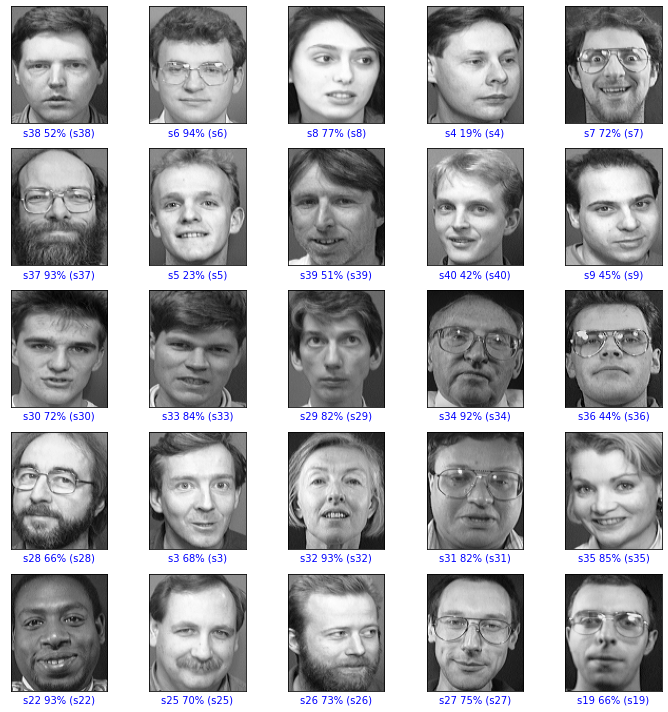

In [ ]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
imgs = []
for img_path in test_df['Image_path']:
  imgs.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
imgs = np.array(imgs) / 255.0
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plot_image(i, predictions[i], test['Label'], imgs)
plt.tight_layout()
plt.show()